In [1]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as sci

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import r2_score,mean_squared_error

from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
import xgboost
from xgboost import XGBRegressor

from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve

ModuleNotFoundError: No module named 'xgboost'

In [2]:
df = pd.read_excel('Capstone Project.xlsx')

In [3]:
df_bkp =  pd.read_excel('Capstone Project.xlsx')

### About the data:
#### Cement, slag, ash, water,superplastic,coarseagg,fineagg -> % of each to be mixed in the cement mixture used for various purposes.
#### Age is the no. of days the cement is aged
#### Strength -> Target column -> Strength of the final mixture

In [4]:
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


### Function for custom summary

In [5]:
def custom_summary(df): #parameters?? df = dataframe original data of mtcars
    
    result = []
    
    for col in df.columns:
        
        if df[col].dtype != 'O':
        
            stats = OrderedDict ({
                'Feature_Name' : col,
                'Count':df[col].count(),
                'Minimum':df[col].min(),
                'Quarter 1':df[col].quantile(0.25), 
                "Mean":df[col].mean(),
                'Median':df[col].median(),
                'Quarter 3':df[col].quantile(0.75),
                'Maximum':df[col].max(),
                "Variance":df[col].var(),
                'Standard Deviation':df[col].std(),
                "Kurtosis":df[col].kurt(),
                'Skewness':df[col].skew() ,
                'IQR':df[col].quantile(0.75) - df[col].quantile(0.25)
            })
            
            result.append(stats)
        
        
    result_df = pd.DataFrame(result)
    
    skewtype =[]
    
    for i in result_df['Skewness']:
        if i<=-1:
            skewtype.append('Highly Negatively Skewed')
        elif i<= -0.5:
            skewtype.append('Moderately Negatively Skewed')
        elif -0.5 < i < 0 :
            skewtype.append('Approx Normal Distribution (-ve)')
        elif 0 <= i < 0.5:
            skewtype.append('Approx Normal Distribution (+ve)')
        elif 0.5<= i < 1:
            skewtype.append('Moderately Positively Skewed')
        elif i >= 1:
            skewtype.append('Highly Positively Skewed')
    
    result_df['Skew_Type'] = skewtype
    
    k_type = []
    
    for i in result_df['Kurtosis']:
        if i <=  -1:
            k_type.append('Highly Platykurtic Curve')
        elif -1 < i <= -0.5:#-.9 to .9
            k_type.append('Moderately Platykurtic Curve')
        elif -0.5 < i <= 0.5: #-1,-2,-3...
            k_type.append('Mesokurtic Curve')
        elif 0.5<= i < 1:
            k_type.append('Moderately Leptokurtic Curve')
        elif i >= 1:
            k_type.append('Highly Leptokurtic Curve')
            
        
    
    result_df['Kurtosis_Type'] = k_type
    
    
    #Outlier detection
    

    Upper_limit = stats['Quarter 3'] + 1.5*stats['IQR']
    
    lower_limit = stats['Quarter 1'] -1.5*stats['IQR']
    
    if len([x for x in df[col] if (x < lower_limit) or (x > Upper_limit)]) > 0:
        
        outlier_comment = 'has outliers'
        outlier_percentage = len([x for x in df[col] if (x < lower_limit) or (x > Upper_limit)])/len(df)
    else:
        oulier_comment = 'no outliers'
        
        outlier_percentage = 0
        
    result_df['outlier_comment'] = outlier_comment
    
    result_df['outlier_percentage'] = outlier_percentage
   
    return result_df

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
custom_summary(df)

,Feature_Name,Count,Minimum,Quarter 1,Mean,Median,Quarter 3,Maximum,Variance,Standard Deviation,Kurtosis,Skewness,IQR,Skew_Type,Kurtosis_Type,outlier_comment,outlier_percentage
0,cement,1005,102.00,190.70,278.631343,265.0,349.00,540.0,10887.724744,104.344261,-0.432458,0.564959,158.30,Moderately Positively Skewed,Mesokurtic Curve,has outliers,0.00796
1,slag,1005,0.00,0.00,72.043483,20.0,142.50,359.4,7425.407978,86.170807,-0.407179,0.855225,142.50,Moderately Positively Skewed,Mesokurtic Curve,has outliers,0.00796
2,ash,1005,0.00,0.00,55.536318,0.0,118.30,200.1,4122.663231,64.207969,-1.366694,0.497231,118.30,Approx Normal Distribution (+ve),Highly Platykurtic Curve,has outliers,0.00796
3,water,1005,121.80,166.60,182.075323,185.7,192.90,247.0,455.367179,21.339334,0.167329,0.034433,26.30,Approx Normal Distribution (+ve),Mesokurtic Curve,has outliers,0.00796
4,superplastic,1005,0.00,0.00,6.033234,6.1,10.00,32.2,35.046006,5.919967,1.695396,0.980604,10.00,Moderately Positively Skewed,Highly Leptokurtic Curve,has outliers,0.00796
5,coarseagg,1005,801.00,932.00,974.376816,968.0,1031.00,1145.0,6018.604691,77.579667,-0.583049,-0.065256,99.00,Approx Normal Distribution (-ve),Moderately Platykurtic Curve,has outliers,0.00796
6,fineagg,1005,594.00,724.30,772.688259,780.0,822.20,992.6,6454.585440,80.340435,-0.105881,-0.252353,97.90,Approx Normal Distribution (-ve),Mesokurtic Curve,has outliers,0.00796
7,age,1005,1.00,7.00,45.856716,28.0,56.00,365.0,4062.110923,63.734692,11.961963,3.253974,49.00,Highly Positively Skewed,Highly Leptokurtic Curve,has outliers,0.00796
8,strength,1005,2.33,23.52,35.250378,33.8,44.87,82.6,265.195212,16.284815,-0.305309,0.395696,21.35,Approx Normal Distribution (+ve),Mesokurtic Curve,has outliers,0.00796


## Concluding Descriptive Stats
### All the columns are having outliers
### Age is Highly Positive Skewed and all other columns are Moderately Positive Skewed
### Generally Data is Platykurtic
### Age is a yearly data as max is 365

### Outlier Detection & Treatment

In [8]:
# Performing Outlier Treatment

def outlier_treatment(data,col,strategy="median",method="quartile"):  #method = std,quartile ; startegy = mean,median
    col_data = data[col]
    
#finding outliers

    if method =="quartile":
        q1 = data[col].quantile(0.25)
        q2 = data[col].quantile(0.5)
        q3 = data[col].quantile(0.75)    
        
        iqr = q3 - q1
        
        low_limit = q1 - (1.5*iqr)
        up_limit = q3 + (1.5*iqr)    
        
    elif method =="std":
        std_dev = data[col].std()
        col_mean = data[col].mean()
        
        lower_limit = col[mean] - (2*std_dev)
        upper_limit = col[mean] + (2*std_dev)
        
    else:
        print("Pass the correct method!!")
        
        
# Replacing the outliers

    outliers = data.loc[(col_data < low_limit) | (col_data > up_limit), col]
    outlier_density = outliers / len(data)
    
    #if len(outliers) == 0:
        #print(f"column {col} does not have any outliers")
    #else:
        #print(f"column {col} has outliers and they are", outliers)
        
        
    if strategy=='median':
        data.loc[(col_data < low_limit) | (col_data > up_limit), col] = data[col].median()
        
    elif strategy == 'mean':
        data.loc[(col_data < low_limit) | (col_data > up_limit), col] = data[col].mean()
        
    else:
        print("Pass the correct strategy!!")
        
    return(data)

### ODT (Outlier Detection) Plots

In [10]:
def odt_plots(data,col):
    f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,8))
    
    # Plotting Boxplot
    sns.boxplot(data[col], ax = ax1)
    ax1.set_title('Boxplot for '+ col)
    ax1.set_xlabel('Boxplot')
    ax1.set_ylabel('Values')
    
    # Plotting Histogram with Outliers
    sns.distplot(data[col], ax = ax2, fit = sci.norm , color="red")
    ax2.axvline(data[col].mean(),color = "orange")
    ax2.axvline(data[col].median() ,color = "black" , linestyle = "solid")
    ax2.set_title('Histogram for ' + col + ' with Outliers')
    ax2.set_xlabel('Density')
    ax2.set_ylabel('Values')
    
    # Performing outlier treatment - Histogram without Outliers
    df1 = outlier_treatment(data,col)
    sns.distplot(df1[col], ax = ax3, fit = sci.norm , color="green")
    ax3.axvline(df1[col].mean(),color = "orange")
    ax3.axvline(df1[col].median() ,color = "black" , linestyle = "solid")
    ax3.set_title('Histogram for ' + col + ' without Outliers')
    ax3.set_xlabel('Density')
    ax3.set_ylabel('Values')
    

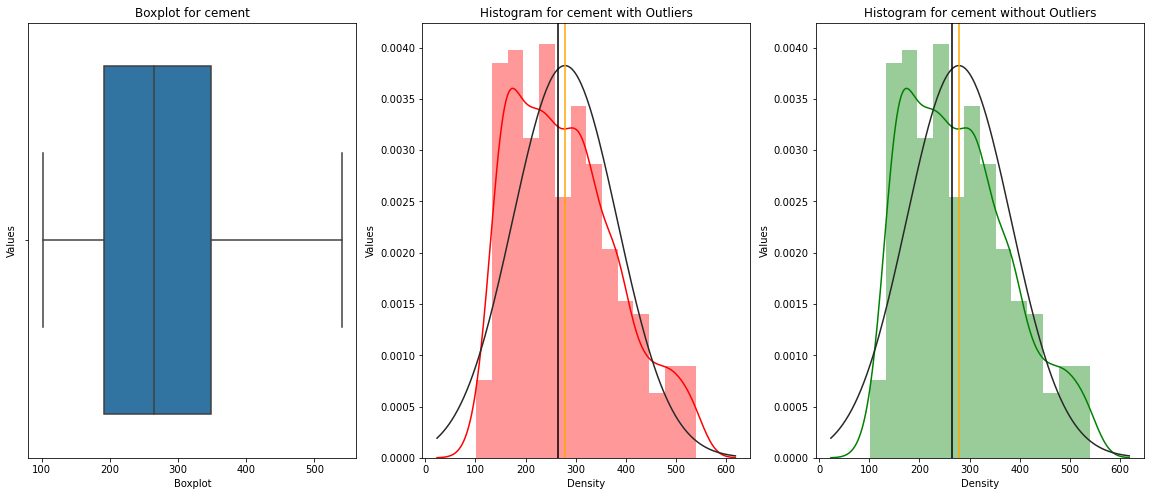

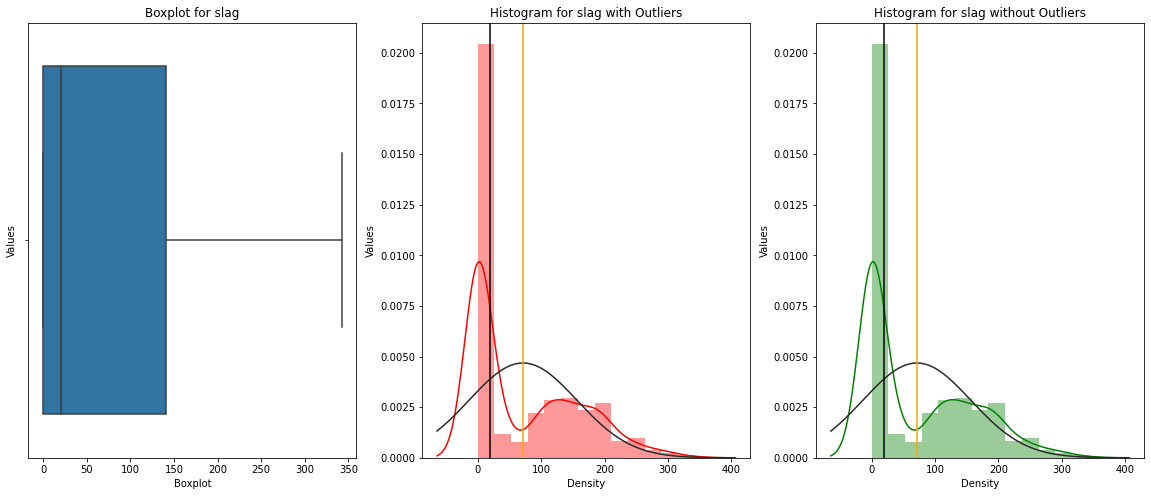

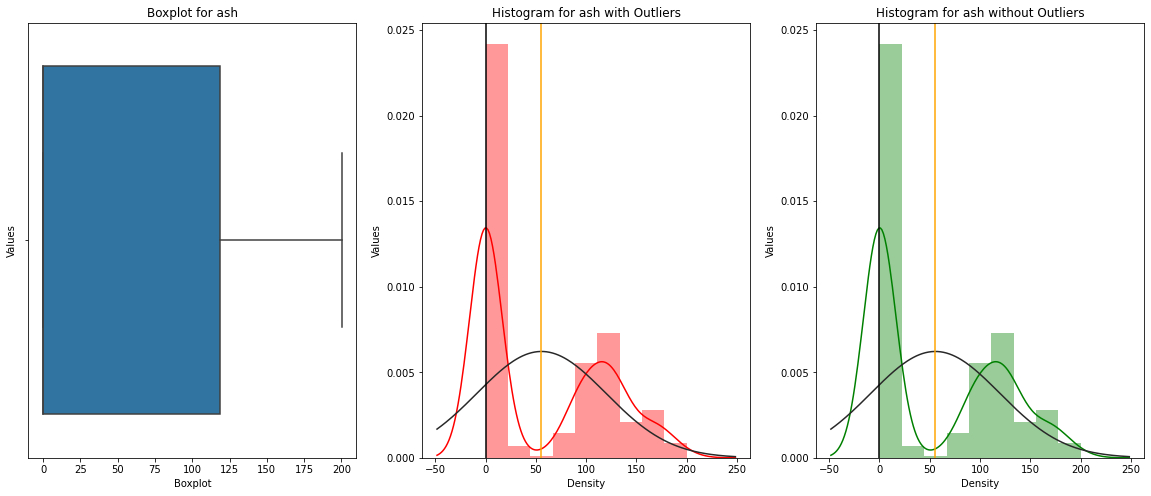

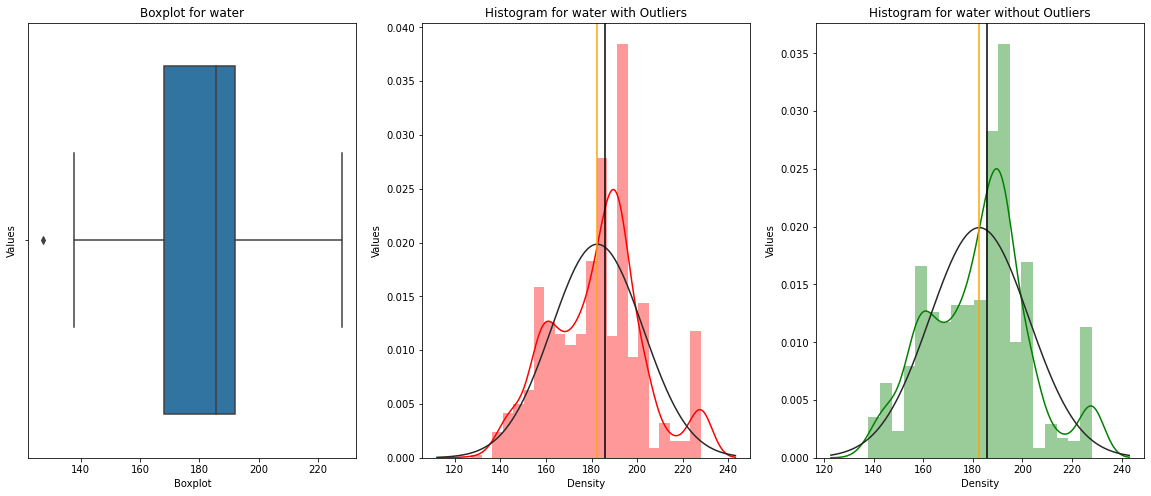

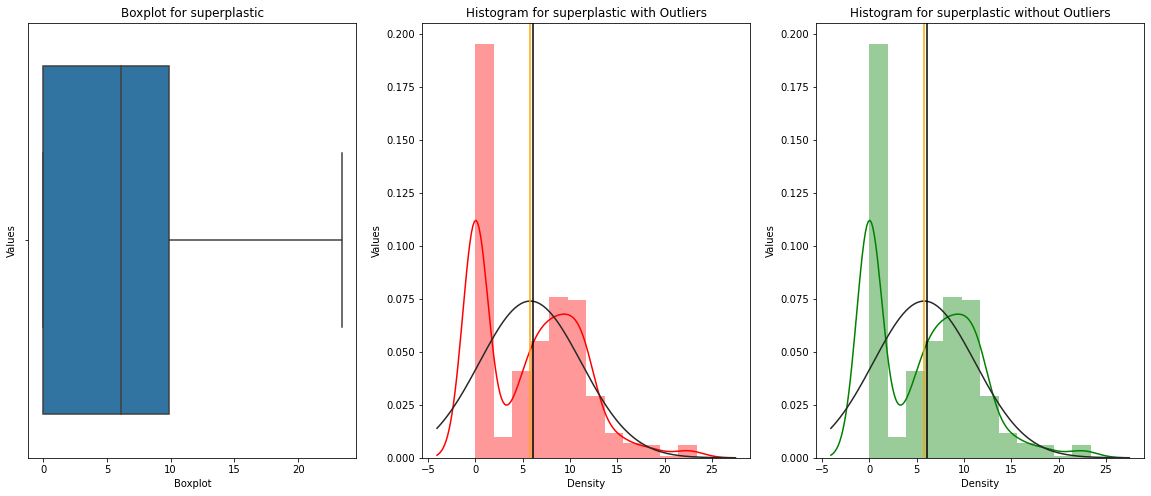

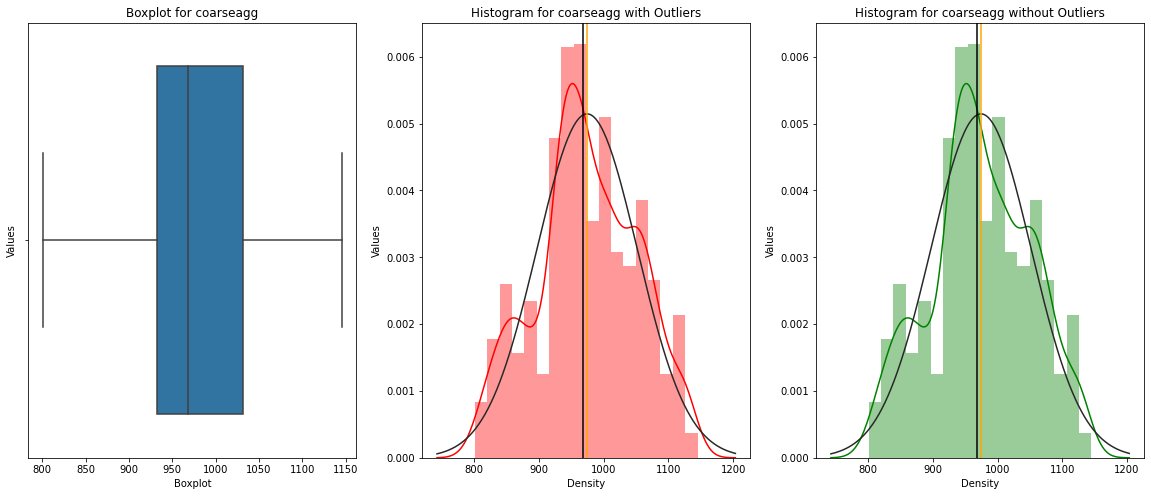

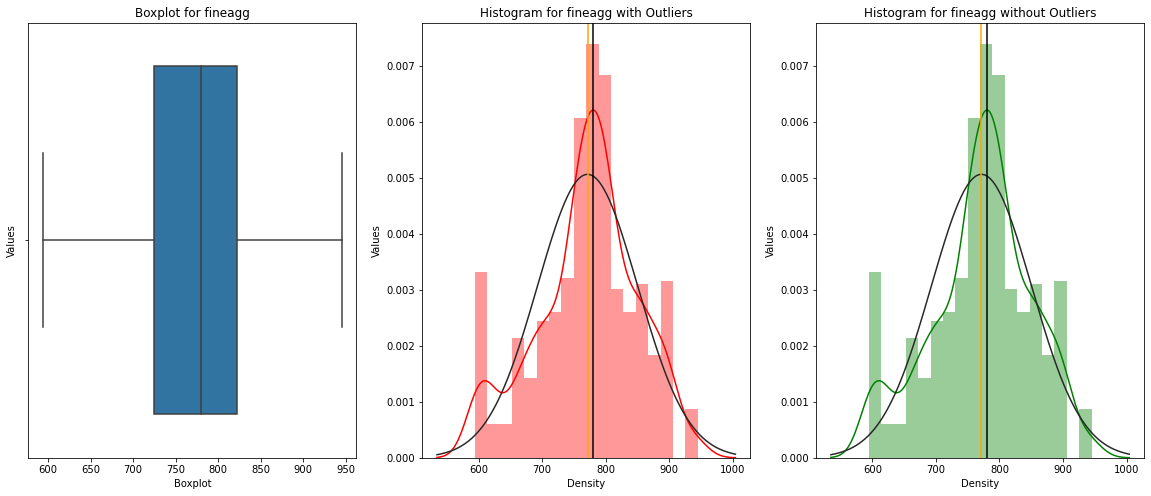

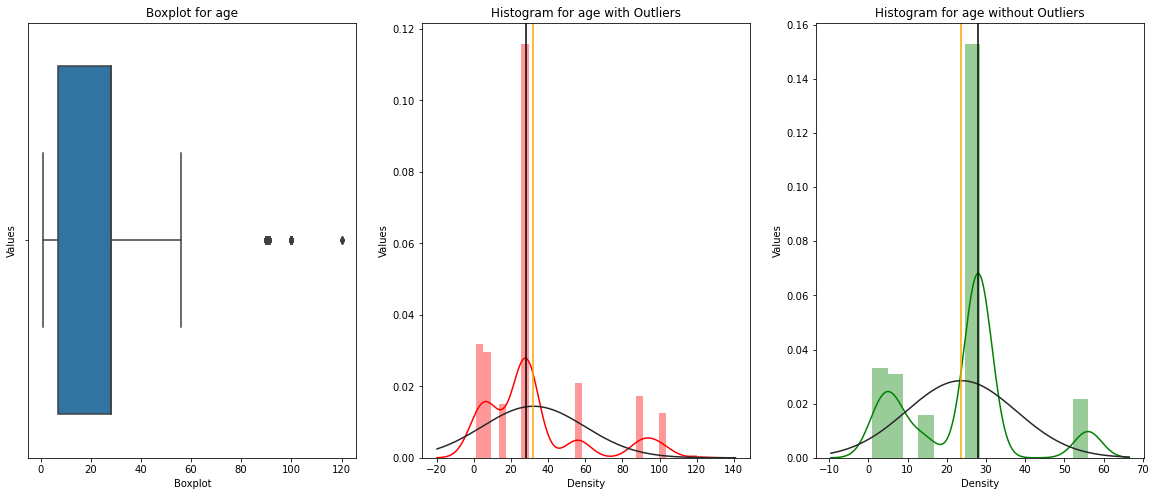

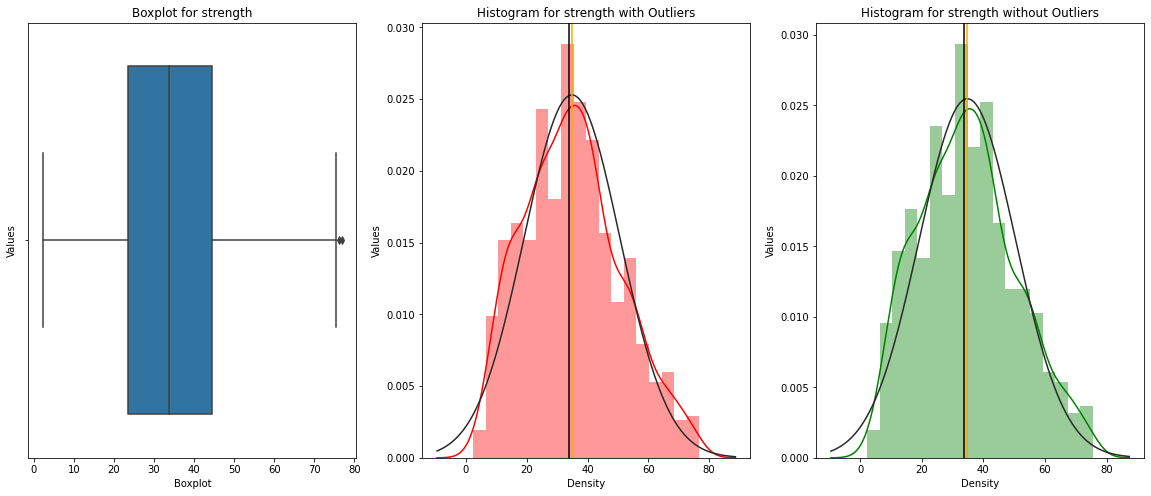

In [11]:
for col in df.columns:
    odt_plots(df,col)

In [12]:
for col in df.columns:
    df = outlier_treatment(df,col)

## Finding Correlation

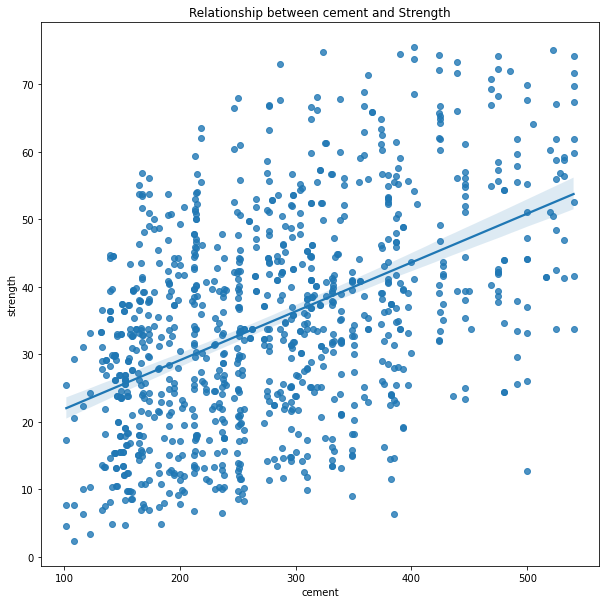

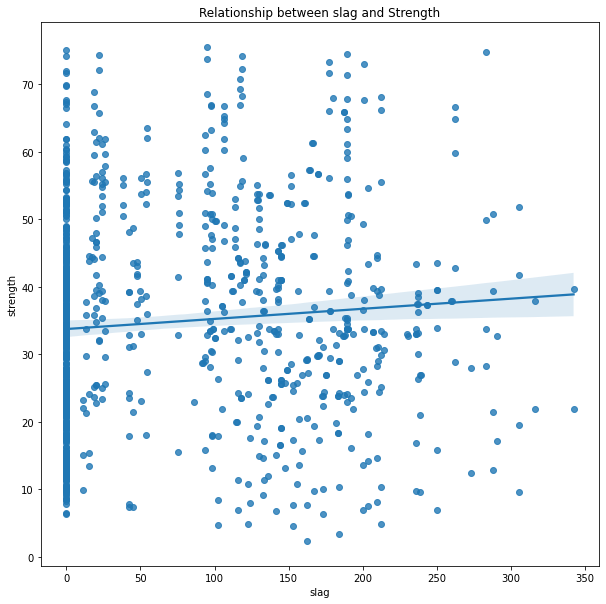

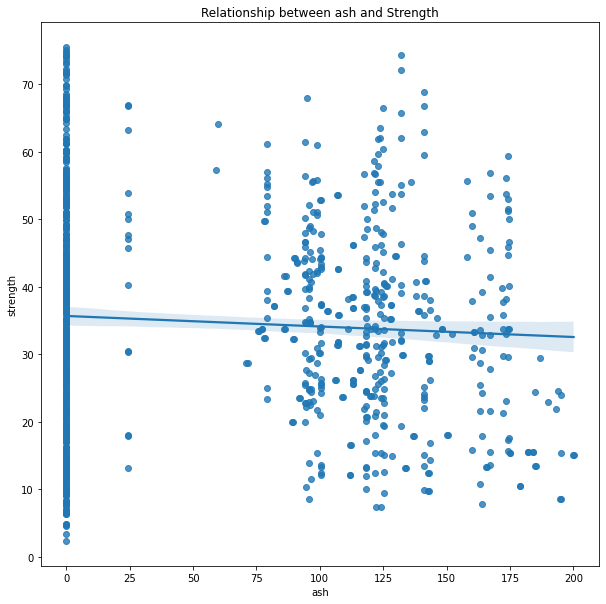

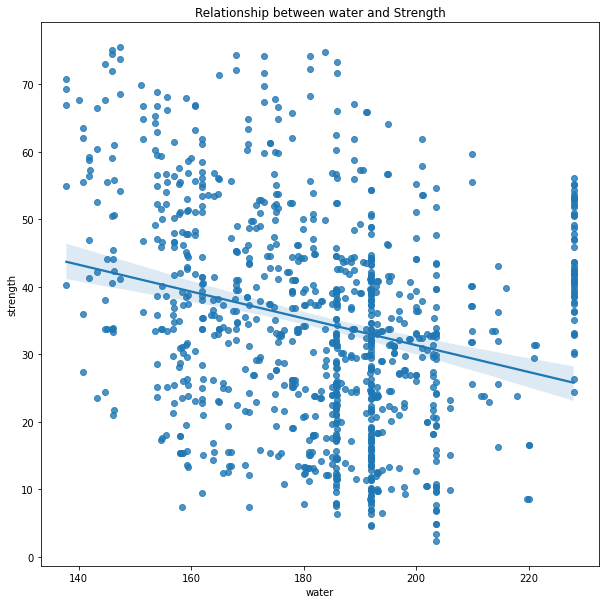

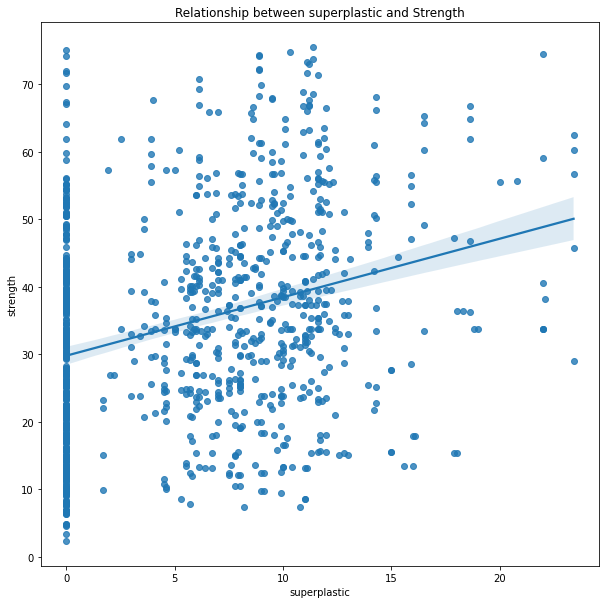

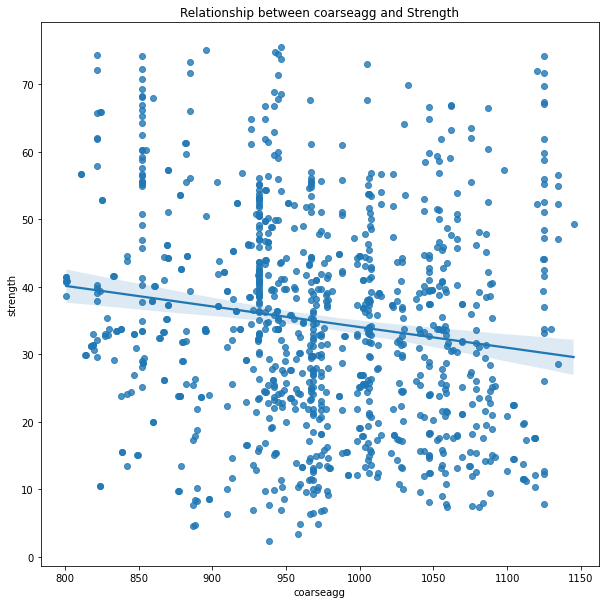

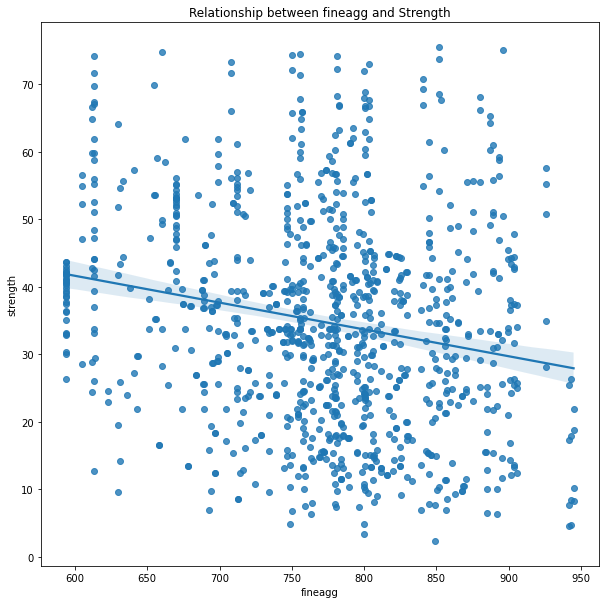

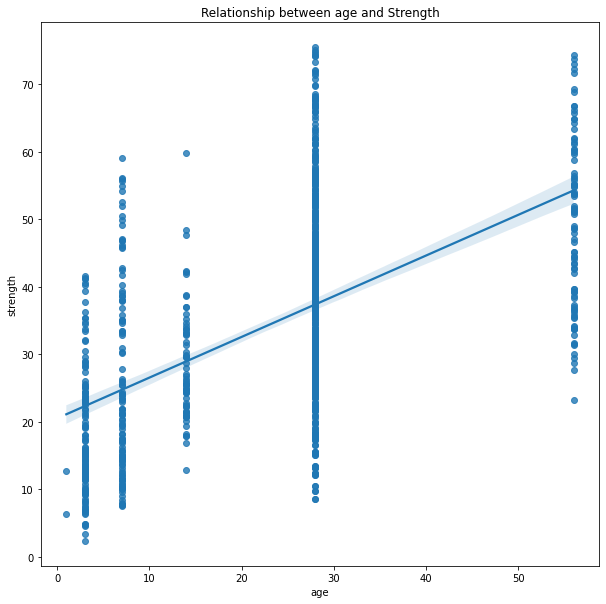

In [13]:
# Performing Regression Analysis

for col in df.columns:
    if col != 'strength':
        
        f,ax = plt.subplots(figsize = (10,10))
        sns.regplot(x = df[col], y = df['strength']).set_title(f'Relationship between {col} and Strength')
        

In [ ]:
# Positive correlation - Cement, slag, superplastic, age
# Negative correlation - ash, water, coarseagg, fineagg
# No correlation - 

In [14]:
# Finding correlation with the target

def correlation_target(data, target_col):
    data_new = data.drop([target_col], axis=1)
    indep_cols = data_new.columns
    
    correlation_result =[]
    
    for col in indep_cols:
        correlation_result.append(data[target_col].corr(data[col]))
        
    result_df = pd.DataFrame([indep_cols,correlation_result], index=['Variable','Correlation']).T
    
    
    return result_df.sort_values('Correlation',ascending = False)

In [15]:
correlation_target(df,'strength')

,Variable,Correlation
7,age,0.538574
0,cement,0.481818
4,superplastic,0.298341
1,slag,0.081518
2,ash,-0.063853
5,coarseagg,-0.151378
6,fineagg,-0.199586
3,water,-0.253747


In [ ]:
# Correlation - age > cement > superplastic > water > fineagg > coarseagg > slag > ash

## MultiColinearity Check

<AxesSubplot:>

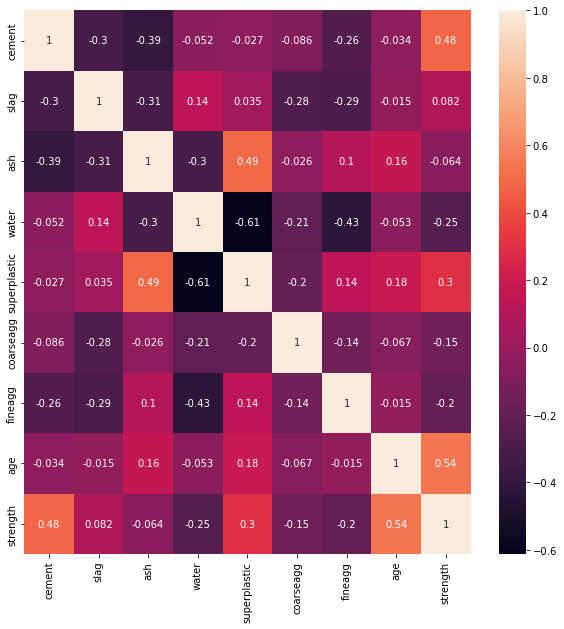

In [16]:
# Multicolinearity check

corr = df.corr()
f,ax = plt.subplots(figsize = (10,10))
sns.heatmap(corr, annot=True)

In [ ]:
# Multicollinearity:
# cement vs slag, cement vs ash, slag vs ash, ash vs superplastic, water vs ash, superplastic vs water, fineagg vs water

In [ ]:
# Multicollinearity check2 - using VIF

# 1. Another method to find out multicollinearity is Variance inflation factor (VIF)
# 2. Formula - VIF = 1/(1-r2_score)
# 3. In this, we regress every independent variable with all the other independent variables and find out the r2_Score.
# 4. We use this r2_Score in the above VIF formula in order to check the VIF number.
# 5. If VIF > 5, then we say multicollinearity exists.


In [17]:
def vif_factor(indep_var):
    vif_df = pd.DataFrame()
    vif_df['Featues'] = indep_var.columns
    vif_df['VIF'] = [variance_inflation_factor(indep_var.values, i) for i in range(indep_var.shape[1])]
    
    
    return vif_df.sort_values('VIF',ascending=False)

In [18]:
vif_factor(df.drop('strength',axis=1))

,Featues,VIF
5,coarseagg,86.289779
3,water,79.095022
6,fineagg,67.639713
0,cement,13.682820
4,superplastic,5.166794
2,ash,4.349037
7,age,4.056114
1,slag,3.166799


### Performing PCA - To remove Collinearity

In [19]:
def apply_pca(X):
    
    cols = []
    n_component = len(X.columns)
    
    # Performing STandard Scaler
    
    from sklearn.preprocessing import StandardScaler 
    X = StandardScaler().fit_transform(X)
    
    
    from sklearn.decomposition import PCA
    
    for i in range(1,n_component):
        pca = PCA(n_components = i)
        p_component = pca.fit_transform(X)
        evr = np.cumsum(pca.explained_variance_ratio_)
        
        if evr[i-1] > 0.9:
            n_components = i
            break
            
    print(evr)
    
    
    # Creating a dataframe
    
    for i in range(1,n_components + 1):
        cols.append("PC_"+str(i))
        
        
    pca_df = pd.DataFrame(data = p_component, columns = cols)
    
    return pca_df

In [20]:
X = df.drop('strength', axis=1)
y = df[['strength']]

In [21]:
df_pca = apply_pca(X)

[0.27952664 0.46091045 0.61178131 0.74701754 0.86791701 0.96995775]


In [22]:
df_pca

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6
0,1.692846,1.606397,-1.168932,-0.059845,0.134745,0.891710
1,-1.886438,-0.528990,-1.254991,-0.321152,1.219541,-0.355129
2,-0.832703,-0.261381,-0.478491,0.321900,-1.222801,-0.026238
3,2.651913,0.926840,-0.053065,-0.713876,-0.856156,-0.223176
4,0.744898,1.177626,-0.638554,-0.905383,1.292588,0.731219
...,...,...,...,...,...,...
1000,-1.918540,0.490881,-0.985539,-0.575022,-0.780014,-0.749713
1001,-0.729719,-1.694758,2.162369,3.059333,0.133955,-0.303078
1002,-0.555993,1.246900,0.754709,0.218404,-0.317153,-0.381296
1003,2.588588,0.034434,0.467343,-0.755102,-1.281957,-0.474470


In [23]:
df_pca.corr()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6
PC_1,1.000000e+00,-3.802200e-16,9.763522e-17,8.849405e-17,-4.567031e-16,-8.372511e-17
PC_2,-3.802200e-16,1.000000e+00,8.647927e-17,1.780983e-16,-1.469599e-16,-1.487997e-16
PC_3,9.763522e-17,8.647927e-17,1.000000e+00,-1.347621e-16,8.199996e-17,-2.114552e-18
PC_4,8.849405e-17,1.780983e-16,-1.347621e-16,1.000000e+00,-6.609169e-17,1.019154e-16
PC_5,-4.567031e-16,-1.469599e-16,8.199996e-17,-6.609169e-17,1.000000e+00,2.198049e-16
PC_6,-8.372511e-17,-1.487997e-16,-2.114552e-18,1.019154e-16,2.198049e-16,1.000000e+00


In [24]:
vif_factor(df_pca)

,Featues,VIF
5,PC_6,1.0
0,PC_1,1.0
1,PC_2,1.0
4,PC_5,1.0
2,PC_3,1.0
3,PC_4,1.0


In [29]:
df_new = df_pca.join(df[['strength']], how='left')
df_new.dropna(inplace=True)

## Model Building
### 1. Normal Model Building
### 2. Cross Validation
### 3. Hyperparameter Tuning

In [26]:
def train_and_test_split(X,y,test_size = 0.3, random_state = 100):
    
    from sklearn.model_selection import train_test_split
    
    return train_test_split(X,y,test_size=test_size,random_state=random_state)

In [27]:
def build_model(model,model_name,X,y):
    
    X_train,X_test,y_train,y_test = train_and_test_split(X,y)
    
    model.fit(X_train,y_train)
    
    y_pred = model.predict(X_test)
    
    r2score = r2_score(y_test,y_pred)
    
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    
    temp = [model_name,r2score,rmse]
    
    return temp

In [34]:
build_model(LinearRegression(),'Linear_Regression',X,y)

['Linear_Regression', 0.6844634340334348, 9.044230799086272]

In [35]:
def build_multiple_model(X,y):
    
    col_names = ['Model_name','r2_Score','RMSE']
    
    result_df = pd.DataFrame(columns=col_names)
    
    result_df.loc[len(result_df)] = build_model(LinearRegression(),'Linear_regression',X,y)
    result_df.loc[len(result_df)] = build_model(Lasso(),'Lasso',X,y)
    result_df.loc[len(result_df)] = build_model(Ridge(),'Ridge',X,y)
    result_df.loc[len(result_df)] = build_model(DecisionTreeRegressor(),'Decision_Tree_Regressor',X,y)
    result_df.loc[len(result_df)] = build_model(KNeighborsRegressor(),'KNN_Regressor',X,y)
    result_df.loc[len(result_df)] = build_model(SVR(),'Support_vector_Regressor',X,y)
    result_df.loc[len(result_df)] = build_model(RandomForestRegressor(),'Random_Forest_Regressor',X,y)
    result_df.loc[len(result_df)] = build_model(AdaBoostRegressor(),'AdaBoostRegressor',X,y)
    result_df.loc[len(result_df)] = build_model(GradientBoostingRegressor(),'GradientBoostingRegressor',X,y)
    result_df.loc[len(result_df)] = build_model(XGBRegressor(),'XGBRegressor',X,y)
    
    
    return result_df.sort_values('r2_Score',ascending=False)

In [36]:
build_multiple_model(X,y)


,Model_name,r2_Score,RMSE
6,Random_Forest_Regressor,0.837152,6.497381
8,GradientBoostingRegressor,0.813584,6.951653
9,XGBRegressor,0.796720,7.259290
3,Decision_Tree_Regressor,0.710554,8.662252
7,AdaBoostRegressor,0.705967,8.730608
1,Lasso,0.686744,9.011492
2,Ridge,0.684464,9.044222
0,Linear_regression,0.684463,9.044231
4,KNN_Regressor,0.539222,10.929310
5,Support_vector_Regressor,0.168434,14.682338


### Performing Cross Validation on above data

In [37]:
def cross_val(X, y, fold = 10):
    
    score_lr = cross_val_score(LinearRegression(),X,y,cv=fold)
    score_ls = cross_val_score(Lasso(),X,y,cv=fold)    
    score_rd = cross_val_score(Ridge(),X,y,cv=fold)    
    score_dtr = cross_val_score(DecisionTreeRegressor(),X,y,cv=fold)   
    score_knr = cross_val_score(KNeighborsRegressor(),X,y,cv=fold)    
    score_svr = cross_val_score(SVR(),X,y,cv=fold)
    score_rfr = cross_val_score(RandomForestRegressor(),X,y,cv=fold)    
    score_ada = cross_val_score(AdaBoostRegressor(),X,y,cv=fold)        
    score_gb = cross_val_score(GradientBoostingRegressor(),X,y,cv=fold)        
    score_xgb = cross_val_score(XGBRegressor(),X,y,cv=fold)        
    
    
    score_list = [score_lr,score_ls,score_rd,score_dtr,score_knr,score_svr,score_rfr,score_ada,score_gb,score_xgb]
    
    model_names = ['Linear Regression','Lasso Regression','Ridge Regression','Decision Tree Regression','K Neighbors Regression',
                  'Support Vector Regression','Random Forest Regression','Ada Boost Regression',
                  'Gradient Boosting Regression','XGB Regression']
                  
    
    result = []
    
    for i in range(0,len(model_names)):
        score_mean = np.mean(score_list[i])
        score_std = np.std(score_list[i])        
        model = model_names[i]
        
        temp = [model, score_mean, score_std]
        
        result.append(temp)
        
        
    result_df = pd.DataFrame(result, columns=['Model_Names','Accuracy','Std Deviation'])
    
    
    return result_df.sort_values('Accuracy', ascending=False)

In [38]:
cross_val(X,y)

,Model_Names,Accuracy,Std Deviation
8,Gradient Boosting Regression,0.822871,0.033606
6,Random Forest Regression,0.809695,0.051743
9,XGB Regression,0.790731,0.067600
3,Decision Tree Regression,0.710971,0.076926
7,Ada Boost Regression,0.705194,0.047099
1,Lasso Regression,0.661488,0.051316
2,Ridge Regression,0.661221,0.051384
0,Linear Regression,0.661221,0.051383
4,K Neighbors Regression,0.573717,0.069159
5,Support Vector Regression,0.197070,0.041064


### Hyperparameter Tuning

In [39]:
def hyperparatuning (X,y,fold = 10):
    
    param_lsrd = {'alpha':[1e-15,1e-13,1e-11,1e-9,1e-7,1e-5,1e-3,1e-1,1,2,3,4,5,6,7,8,9,10,20,30,40,450,60,70,80,90,100,200,300,400,500,]}
    
    param_knn = {"n_neighbors" : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
    
    param_rd = {"n_estimators":[10,20,30,40,50,60,70,80,90,110,130,150,170,190],'min_impurity_decrease':[0.0,0.5,1],
               "bootstrap":[True,False]}
    
    param_ad = {"n_estimators" : [10,20,30,40,50,60,70,80,90,110,130,150,170,190] , "learning_rate" : [0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,10]}
    
    param_gb = {"alpha": [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]}
    
    param_xgb = {"learning_rate":[0.01,0.1,0.5],"gamma":[0.5,0.6,0.7,0.8,0.9,1.0],"reg_lambda":[0.5,0.6,0.7,0.8,0.9,1.0]}
    
    
    tune_ls = GridSearchCV(Lasso(),param_lsrd, cv = fold)
    tune_rd = GridSearchCV(Ridge(),param_lsrd, cv = fold)
    tune_knn = GridSearchCV(KNeighborsRegressor(),param_knn, cv = fold)
    tune_rdf = GridSearchCV(RandomForestRegressor(),param_rd, cv = fold)
    tune_ad = GridSearchCV(AdaBoostRegressor(),param_ad, cv = fold)
    tune_gb = GridSearchCV(GradientBoostingRegressor(),param_gb, cv = fold)
    tune_xgb = GridSearchCV(XGBRegressor(),param_xgb, cv = fold)
    
    
    tune_ls.fit(X,y)
    tune_rd.fit(X,y)
    tune_knn.fit(X,y)    
    tune_rdf.fit(X,y)    
    tune_ad.fit(X,y)    
    tune_gb.fit(X,y)    
    tune_xgb.fit(X,y)
    
    tunned =[tune_ls,tune_rd,tune_knn,tune_rdf,tune_ad,tune_gb,tune_xgb]
    
    models = ['Lasso Regression','Ridge Regression','K Neighbors Regression','Random Forest Regression',
              'Ada Boost Regression','Gradient Boosting Regression','XGB Regression']
    
    for i in range(0,len(models)):
        
        print(models[i])
        print('Best Parameters',tunned[i].best_params_)

In [ ]:
# hyperparatuning(X,y)

In [42]:
def cross_val_scoretuned(X, y, fold = 10):
    
    score_lr = cross_val_score(LinearRegression(),X,y,cv=fold)
    score_ls = cross_val_score(Lasso(alpha = 2),X,y,cv=fold)    
    score_rd = cross_val_score(Ridge(alpha = 500),X,y,cv=fold)    
    score_dtr = cross_val_score(DecisionTreeRegressor(),X,y,cv=fold)   
    score_knr = cross_val_score(KNeighborsRegressor(n_neighbors = 4),X,y,cv=fold)    
    score_svr = cross_val_score(SVR(),X,y,cv=fold)
    score_rfr = cross_val_score(RandomForestRegressor(bootstrap = True, min_impurity_decrease = 0.0, n_estimators = 150),X,y,cv=fold)    
    score_ada = cross_val_score(AdaBoostRegressor(learning_rate = 0.9, n_estimators = 90),X,y,cv=fold)        
    score_gb = cross_val_score(GradientBoostingRegressor(alpha = 0.6),X,y,cv=fold)        
    score_xgb = cross_val_score(XGBRegressor(gamma = 0.8, learning_rate = 0.1, reg_lambda = 1.0),X,y,cv=fold)        
    
    
    score_list = [score_lr,score_ls,score_rd,score_dtr,score_knr,score_svr,score_rfr,score_ada,score_gb,score_xgb]
    
    model_names = ['Linear Regression','Lasso Regression','Ridge Regression','Decision Tree Regression','K Neighbors Regression',
                  'Support Vector Regression','Random Forest Regression','Ada Boost Regression',
                  'Gradient Boosting Regression','XGB Regression']
                  
    
    result = []
    
    for i in range(0,len(model_names)):
        score_mean = np.mean(score_list[i])
        score_std = np.std(score_list[i])        
        model = model_names[i]
        
        temp = [model, score_mean, score_std]
        
        result.append(temp)
        
        
    result_df = pd.DataFrame(result, columns=['Model_Names','Accuracy','Std Deviation'])
    
    
    return result_df.sort_values('Accuracy', ascending=False)

In [41]:
cross_val_scoretuned(X,y)

,Model_Names,Accuracy,Std Deviation
8,Gradient Boosting Regression,0.823040,0.033590
9,XGB Regression,0.821211,0.053944
6,Random Forest Regression,0.811606,0.050017
3,Decision Tree Regression,0.708189,0.073211
7,Ada Boost Regression,0.705760,0.045146
1,Lasso Regression,0.661724,0.051464
2,Ridge Regression,0.661252,0.051433
0,Linear Regression,0.661221,0.051383
4,K Neighbors Regression,0.576723,0.073875
5,Support Vector Regression,0.197070,0.041064


## Performing K-means Clustering

In [43]:
# Clustering

from sklearn.cluster import KMeans

In [44]:
# Using the backup data without dropping duplicates

for col in df_bkp:
    df_bkp = outlier_treatment(df_bkp,col)

In [45]:
X = df_bkp.drop('strength',axis=1)
y = df_bkp[['strength']]

In [46]:
cluster = KMeans(n_clusters=2, random_state=100)

In [47]:
labels = cluster.fit_predict(X)

<AxesSubplot:xlabel='cement', ylabel='strength'>

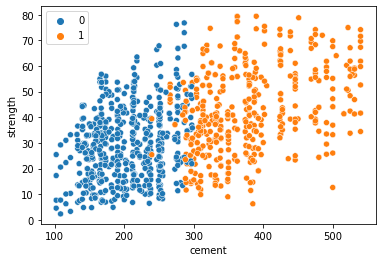

In [48]:
sns.scatterplot(x= X.cement, y = y.strength, hue= labels)

<AxesSubplot:xlabel='age', ylabel='strength'>

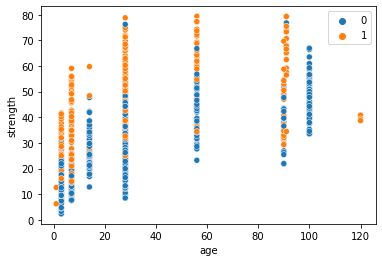

In [49]:
sns.scatterplot(x= X.age, y = y.strength, hue= labels)

<AxesSubplot:xlabel='slag', ylabel='strength'>

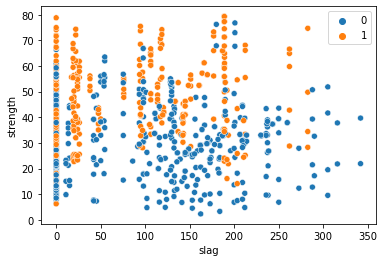

In [50]:
sns.scatterplot(x= X.slag, y = y.strength, hue= labels)

In [51]:
def kmeans_clustering (df,t_col,labels):
    
    columns = df.columns
    r = int(len(df.columns)/2)
    
    if r%2 == 0:
        r = r
    else:
        r = r + 1
        
    
    figure,axis = plt.subplots(r,2, figsize = (15,15))
    a = 0
    for row in range(0,r):
        for col in range(0,2):
            if a!=len(df.columns):
            
                axis[row][col].scatter(df[t_col], df[columns[a]], c = labels)
                axis[row][col].set_xlabel(t_col)
                axis[row][col].set_ylabel(columns[a])
                
                a = a+1
                

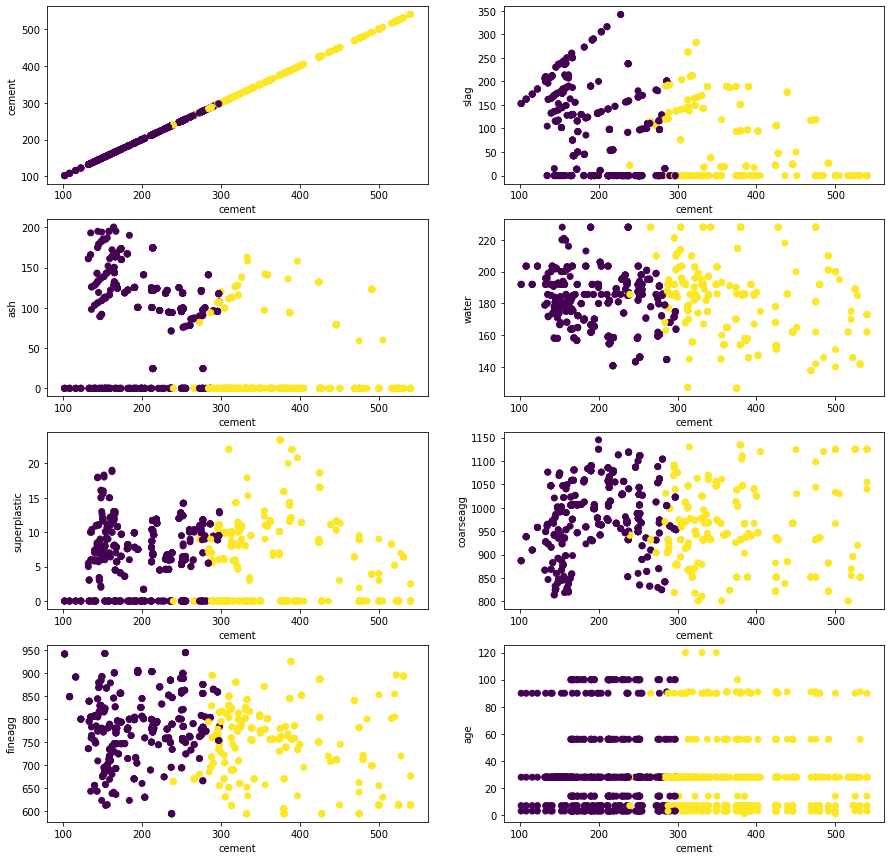

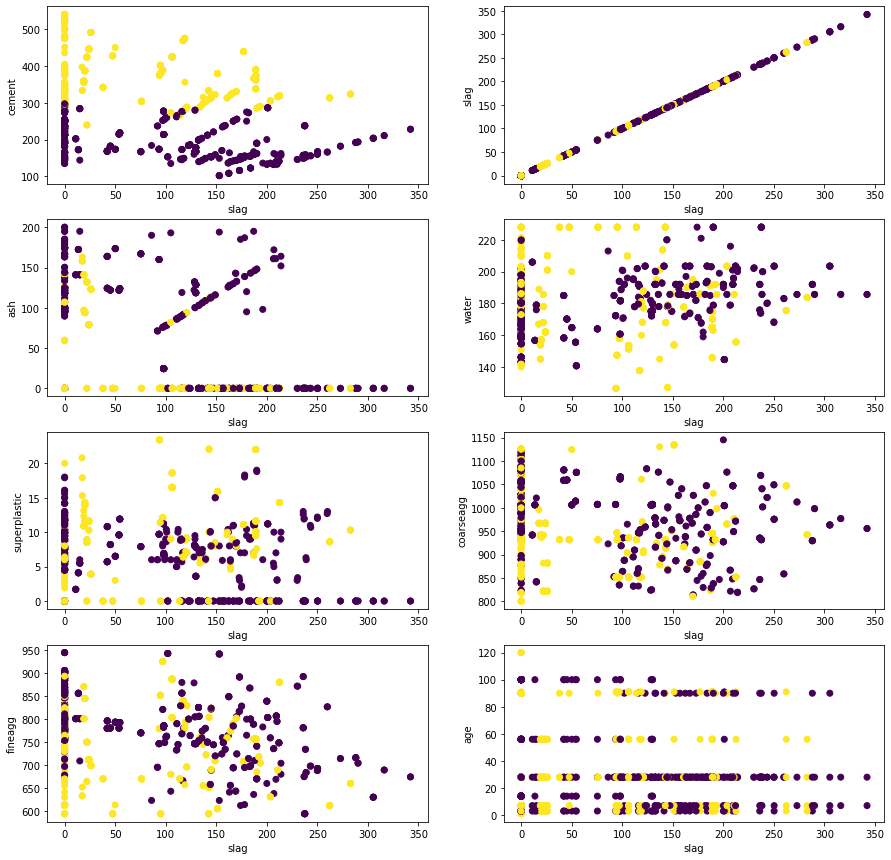

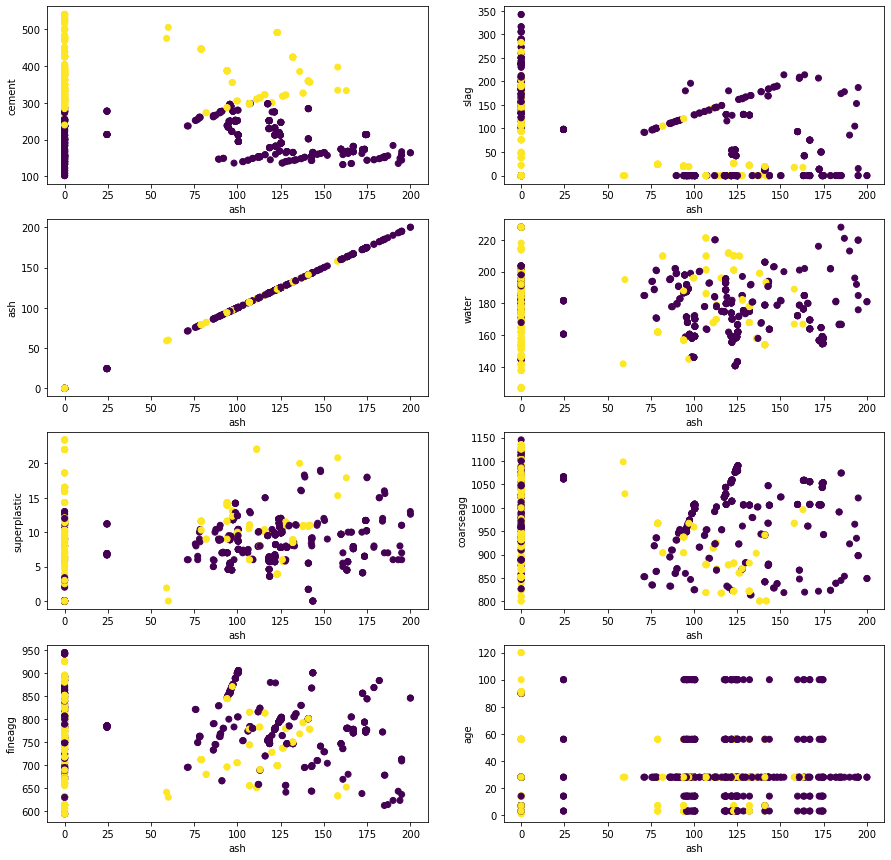

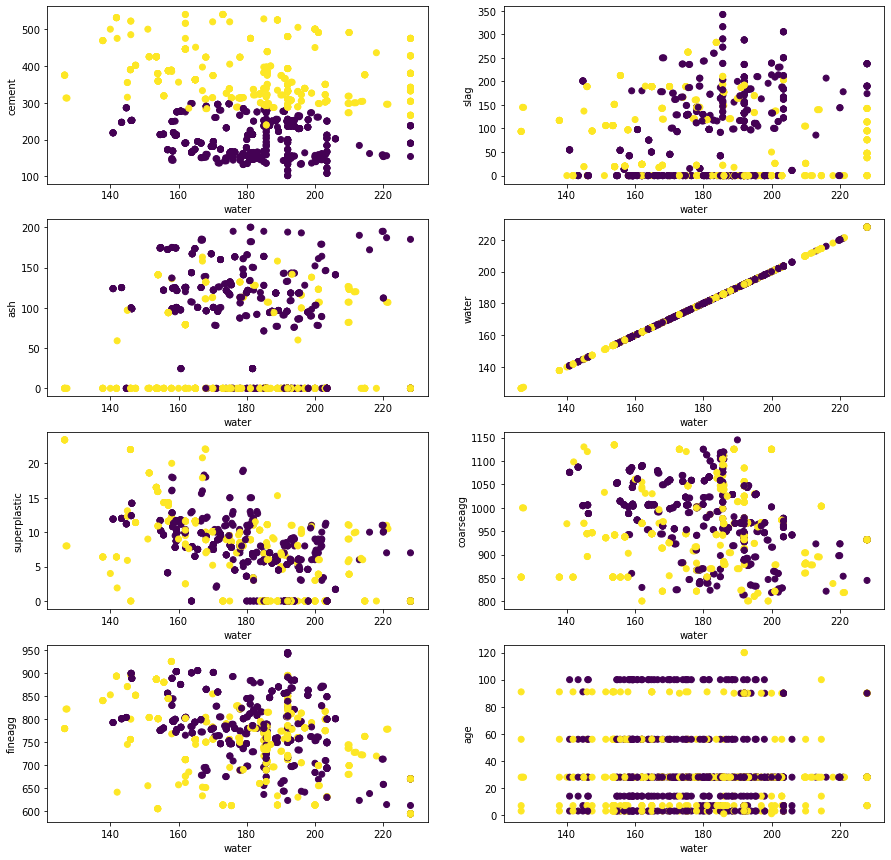

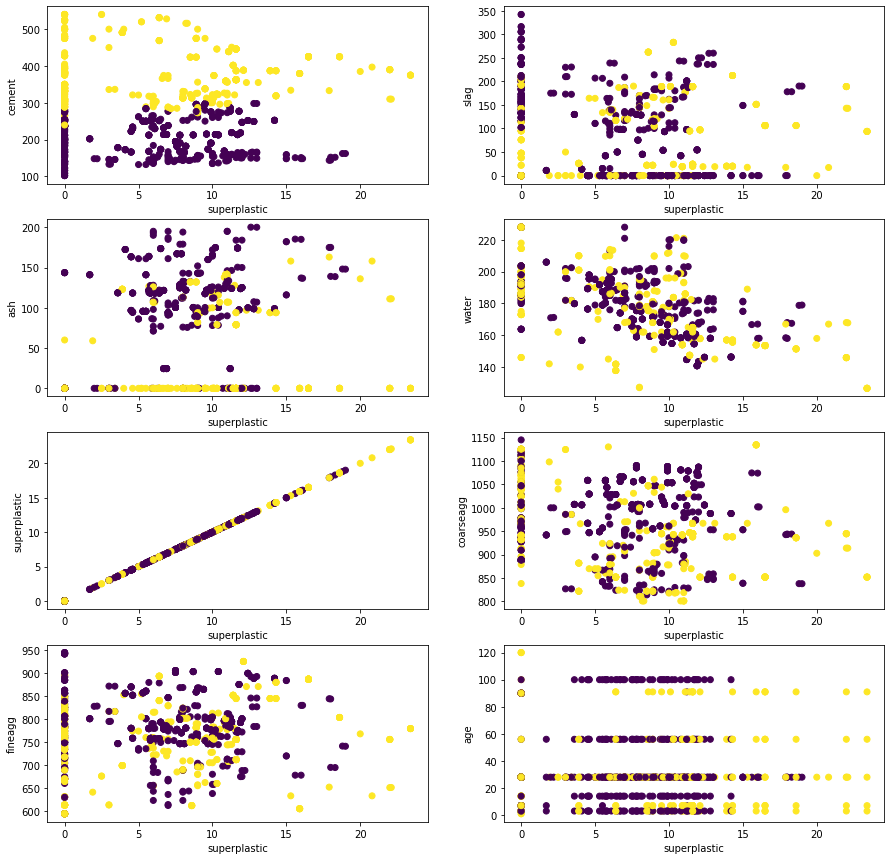

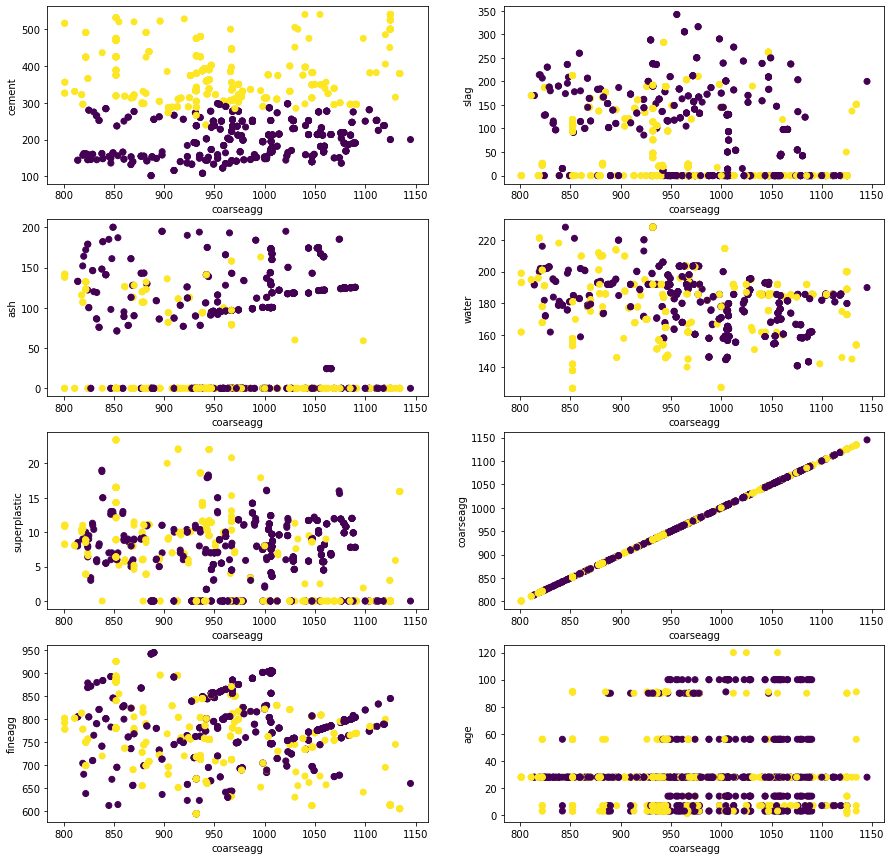

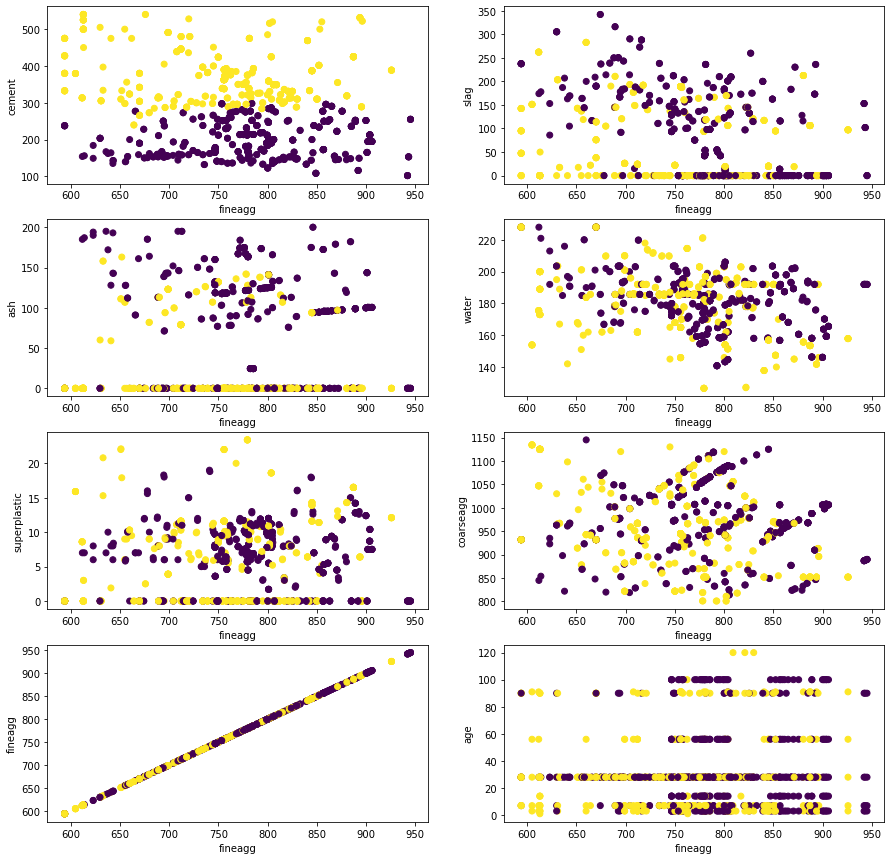

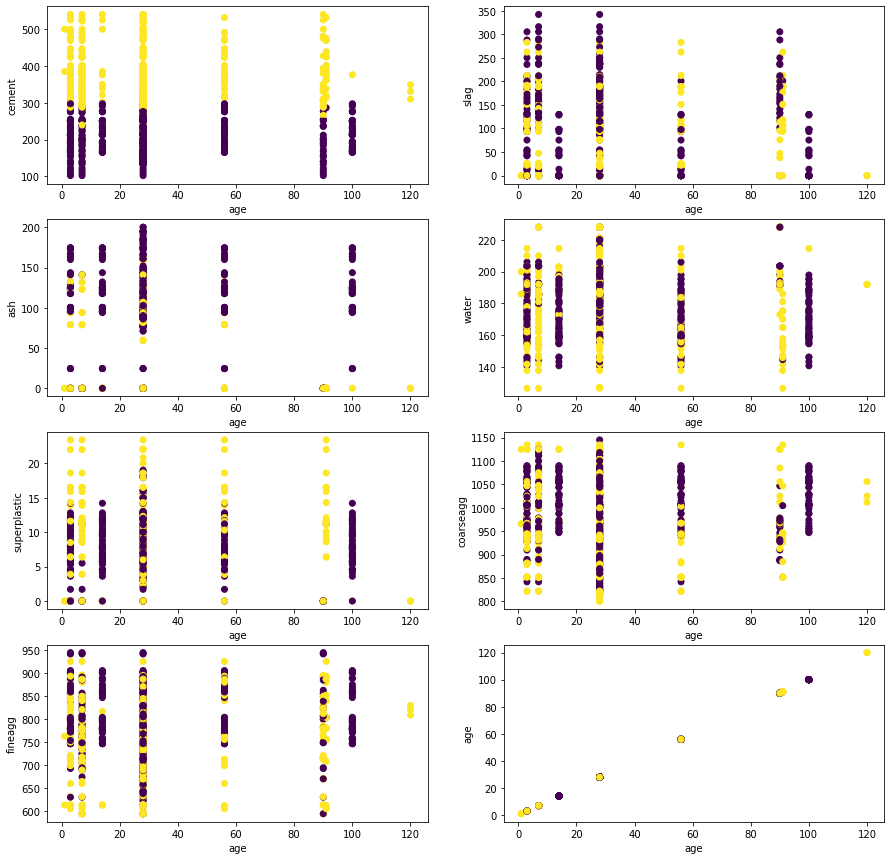

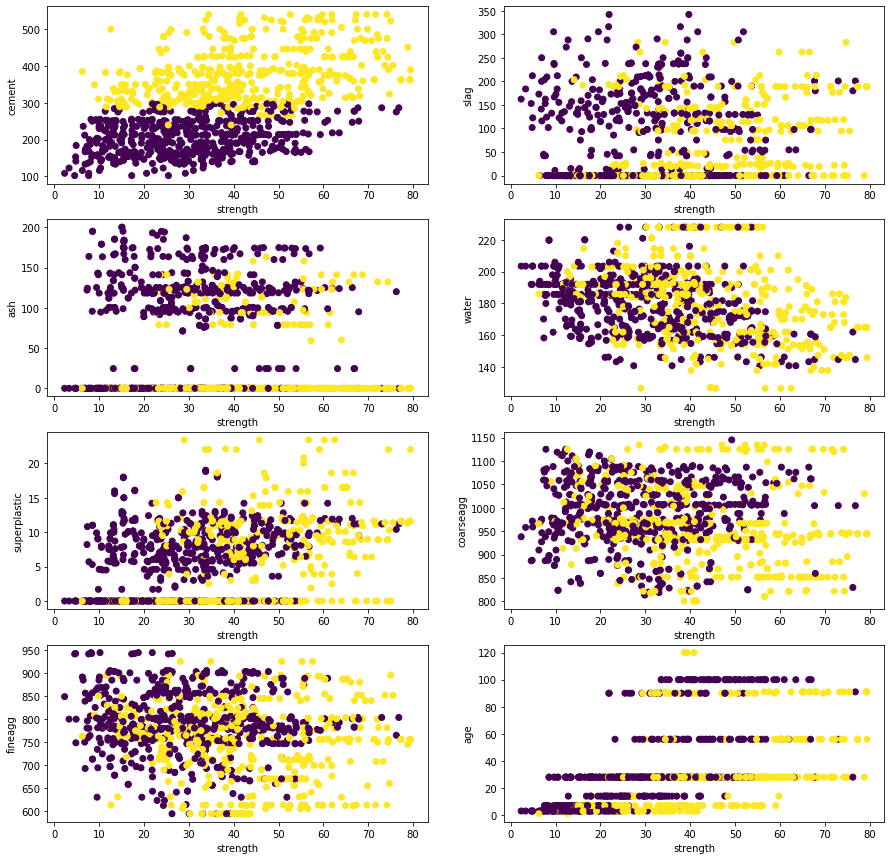

In [52]:
for col in df_bkp.columns:
    
    kmeans_clustering(df_bkp,col,labels)

In [53]:
# Cluster Analysis:
# 1. slag vs cement , water vs cement, ash vs cement, superplastic vs cement, coarseagg vs cement, fineagg vs cement
# 2. cement vs strength

In [54]:
labels_df = pd.DataFrame(labels, columns = ['Labels'])

In [55]:
new_df = df_bkp.join(labels_df, how = 'left')

In [56]:
new_df

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,Labels
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89,0
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51,0
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22,0
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85,1
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29,0
...,...,...,...,...,...,...,...,...,...,...
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29,0
1026,531.3,0.0,0.0,141.8,6.4,852.1,893.7,3,41.30,1
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28,0
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,28,55.06,1


In [57]:
X = new_df.drop('strength',axis=1)
y = new_df[['strength']]

In [58]:
cross_val(X,y)

,Model_Names,Accuracy,Std Deviation
9,XGB Regression,0.899436,0.046856
6,Random Forest Regression,0.886573,0.035093
8,Gradient Boosting Regression,0.875680,0.044947
3,Decision Tree Regression,0.839241,0.046953
7,Ada Boost Regression,0.737439,0.030954
1,Lasso Regression,0.686684,0.062488
2,Ridge Regression,0.686647,0.062316
0,Linear Regression,0.686640,0.062314
4,K Neighbors Regression,0.668430,0.086221
5,Support Vector Regression,0.223931,0.038833


### Feature Importance

In [59]:
X_train,X_test,y_train,y_test = train_and_test_split(X,y,test_size=0.2,random_state=50)

In [60]:
xgb = XGBRegressor()
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

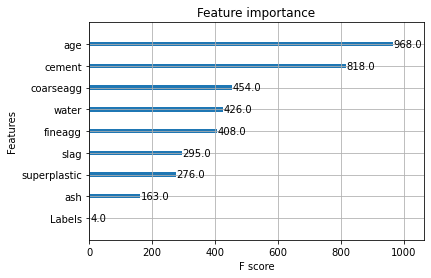

In [61]:
xgboost.plot_importance(xgb)

In [62]:
X = new_df[['age','cement','coarseagg','water','fineagg']]
y = new_df[['strength']]

In [63]:
cross_val(X,y)

,Model_Names,Accuracy,Std Deviation
9,XGB Regression,0.881631,0.049248
6,Random Forest Regression,0.864547,0.042880
8,Gradient Boosting Regression,0.842046,0.039966
3,Decision Tree Regression,0.803610,0.074710
7,Ada Boost Regression,0.699097,0.035551
1,Lasso Regression,0.657591,0.060122
2,Ridge Regression,0.657579,0.060465
0,Linear Regression,0.657579,0.060465
4,K Neighbors Regression,0.645391,0.079298
5,Support Vector Regression,0.252828,0.044987


In [64]:
X = new_df[['age','cement','coarseagg','water','fineagg','slag']]
y = new_df[['strength']]

In [65]:
cross_val(X,y)

,Model_Names,Accuracy,Std Deviation
9,XGB Regression,0.896175,0.047256
6,Random Forest Regression,0.881956,0.036107
8,Gradient Boosting Regression,0.875552,0.046361
3,Decision Tree Regression,0.827064,0.046838
7,Ada Boost Regression,0.729640,0.035007
1,Lasso Regression,0.679548,0.061547
2,Ridge Regression,0.679539,0.061858
0,Linear Regression,0.679539,0.061858
4,K Neighbors Regression,0.656448,0.088739
5,Support Vector Regression,0.261459,0.037619


### Learning Curve Analysis

In [82]:
def generic_lc(model_name, estimator, X, y):
    
    train_size,train_score,test_score = learning_curve(estimator, X, y, cv=10)
    
    train_score = np.mean(train_score, axis=1)
    test_score = np.mean(test_score, axis=1)
    
    plt.plot(train_size,train_score,color="blue")
    plt.plot(train_size,test_score,color="orange")
    
    plt.xlabel('Samples')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve Analysis of ' + model_name)
    
    plt.legend(['Train Score','Test Score'])
    
    return train_size,train_score,test_score

In [67]:
X = new_df.drop('strength',axis=1)
y = new_df[['strength']]

(array([ 92, 301, 509, 718, 927]),
 array([0.9431147 , 0.97746148, 0.97770522, 0.97899358, 0.97974126]),
 array([0.62484752, 0.81978015, 0.86310827, 0.87001022, 0.88751302]))

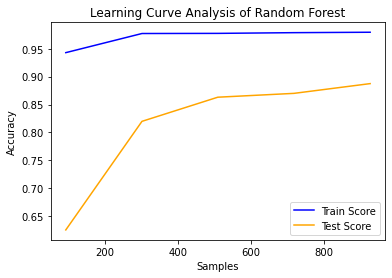

In [83]:
generic_lc("Random Forest",RandomForestRegressor(),X,y)

(array([ 92, 301, 509, 718, 927]),
 array([0.99969628, 0.99758022, 0.9928369 , 0.99207633, 0.99121044]),
 array([0.64715047, 0.83220276, 0.87966735, 0.88045784, 0.89943565]))

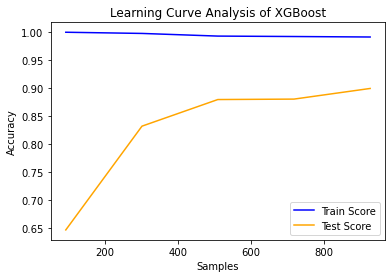

In [84]:
generic_lc("XGBoost",XGBRegressor(),X,y)